In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score

## Configure notebook and get raw data

In [ ]:
# notebook config
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.set_context("notebook")

# get raw data
data_path = Path("../data/MACH_data/data.cleaned.csv")
codebook_path = Path("../data/MACH_data/codebook.txt")
df = pd.read_csv(data_path)

# show raw data
print(f"Shape: {df.shape}")
display(df.head())

## Choose features
Sticking to just the actual question response for now.

In [ ]:

question_responses = ["Q1A", "Q2A", "Q3A", "Q4A", "Q5A", "Q6A", "Q7A", "Q8A", "Q9A", "Q10A", 
                      "Q11A", "Q12A", "Q13A", "Q14A", "Q15A", "Q16A", "Q17A", "Q18A", "Q19A", "Q20A"]
X = df[question_responses].copy()
print(f"Using features: {question_responses}  |  Shape: {X.shape}")
display(X.head())

## Data preprocessing
Scalaing this data is likely not necessary since the data is usually between 1 and 5, with some NA values.

In [9]:
X_clean = X.dropna().copy()
X_clean[question_responses] = X_clean[question_responses].astype(int)
Xs = pd.DataFrame(X_clean, columns=question_responses, index=X_clean.index)
# use only 5000 random datapoints
Xs_sample = Xs.sample(n=5000, random_state=42)
print(f"After preprocessing shape: {Xs_sample.shape}")
display(Xs_sample.head())
display(Xs_sample.describe().T.round(3))

After preprocessing shape: (5000, 20)


,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,Q11A,Q12A,Q13A,Q14A,Q15A,Q16A,Q17A,Q18A,Q19A,Q20A
5860,2,1,3,4,4,3,2,2,3,3,3,4,5,3,5,3,1,5,4,4
61638,4,1,1,1,1,1,1,1,5,4,1,5,1,4,5,1,5,1,5,2
33684,5,5,2,3,5,2,2,2,1,4,1,5,4,2,3,2,2,5,5,5
32572,2,4,3,4,2,3,4,2,3,5,1,5,2,1,2,2,1,4,5,4
2493,2,4,4,2,3,3,3,4,5,4,2,2,1,2,3,3,2,4,3,4


,count,mean,std,min,25%,50%,75%,max
Q1A,5000.0,3.318,1.516,1.0,2.0,4.0,5.0,5.0
Q2A,5000.0,3.312,1.473,1.0,2.0,4.0,5.0,5.0
Q3A,5000.0,2.800,1.432,1.0,2.0,3.0,4.0,5.0
Q4A,5000.0,2.766,1.416,1.0,1.0,3.0,4.0,5.0
Q5A,5000.0,3.626,1.346,1.0,3.0,4.0,5.0,5.0
Q6A,5000.0,2.597,1.482,1.0,1.0,2.0,4.0,5.0
Q7A,5000.0,2.148,1.358,1.0,1.0,2.0,3.0,5.0
Q8A,5000.0,3.130,1.481,1.0,2.0,4.0,4.0,5.0
Q9A,5000.0,3.769,1.404,1.0,3.0,4.0,5.0,5.0
Q10A,5000.0,3.135,1.501,1.0,2.0,3.0,5.0,5.0


## Compute pairwise distances and distance matrix manually
This may not be necessary for the linkage step.

In [16]:
euclidean = pdist(Xs_sample, metric="euclidean")
euclidean_condensed = squareform(euclidean)
manhattan = pdist(Xs_sample, metric="cityblock")
manhattan_condensed = squareform(manhattan)

print(f"Condensed Euclidean shape: {euclidean_condensed.shape}")
print(f"Euclidean 5x5 Slice:\n{euclidean_condensed[0:5, 0:5]}")
print(f"Manhattan Euclidean shape: {manhattan_condensed.shape}")
print(f"Mahattan 5x5 Slice:\n{manhattan_condensed[0:5, 0:5]}")

Condensed Euclidean shape: (5000, 5000)
Euclidean 5x5 Slice:
[[ 0.         10.          7.          7.14142843  7.34846923]
 [10.          0.         10.44030651  9.74679434  9.59166305]
 [ 7.         10.44030651  0.          6.32455532  8.18535277]
 [ 7.14142843  9.74679434  6.32455532  0.          5.91607978]
 [ 7.34846923  9.59166305  8.18535277  5.91607978  0.        ]]
Manhattan Euclidean shape: (5000, 5000)
Mahattan 5x5 Slice:
[[ 0. 38. 25. 23. 26.]
 [38.  0. 37. 37. 38.]
 [25. 37.  0. 22. 29.]
 [23. 37. 22.  0. 21.]
 [26. 38. 29. 21.  0.]]


## Compute linkage (Euclidean vs. Manhattan vs. no distance matrix)
Ward linkage is a special case where pre-computed pairwise distances is invalid since Ward linkage requires raw observations.

In [23]:
Z_single_euclidean = linkage(euclidean_condensed, method="single")
Z_complete_euclidean = linkage(euclidean_condensed, method="complete")
Z_average_euclidean = linkage(euclidean_condensed, method="average")

C:\Users\jeffr\AppData\Local\Temp\ipykernel_13588\1058921424.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_single_euclidean = linkage(euclidean_condensed, method="single")
C:\Users\jeffr\AppData\Local\Temp\ipykernel_13588\1058921424.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_complete_euclidean = linkage(euclidean_condensed, method="complete")
C:\Users\jeffr\AppData\Local\Temp\ipykernel_13588\1058921424.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_average_euclidean = linkage(euclidean_condensed, method="average")


In [24]:
Z_single_manhattan = linkage(manhattan_condensed, method="single")
Z_complete_manhattan = linkage(manhattan_condensed, method="complete")
Z_average_manhattan = linkage(manhattan_condensed, method="average")

C:\Users\jeffr\AppData\Local\Temp\ipykernel_13588\2842111622.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_single_manhattan = linkage(manhattan_condensed, method="single")
C:\Users\jeffr\AppData\Local\Temp\ipykernel_13588\2842111622.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_complete_manhattan = linkage(manhattan_condensed, method="complete")
C:\Users\jeffr\AppData\Local\Temp\ipykernel_13588\2842111622.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_average_manhattan = linkage(manhattan_condensed, method="average")


In [25]:
Z_single_default = linkage(Xs_sample, method="single")
Z_complete_default = linkage(Xs_sample, method="complete")
Z_average_default = linkage(Xs_sample, method="average")
Z_ward = linkage(Xs_sample, method="ward")

## Plot dendrograms

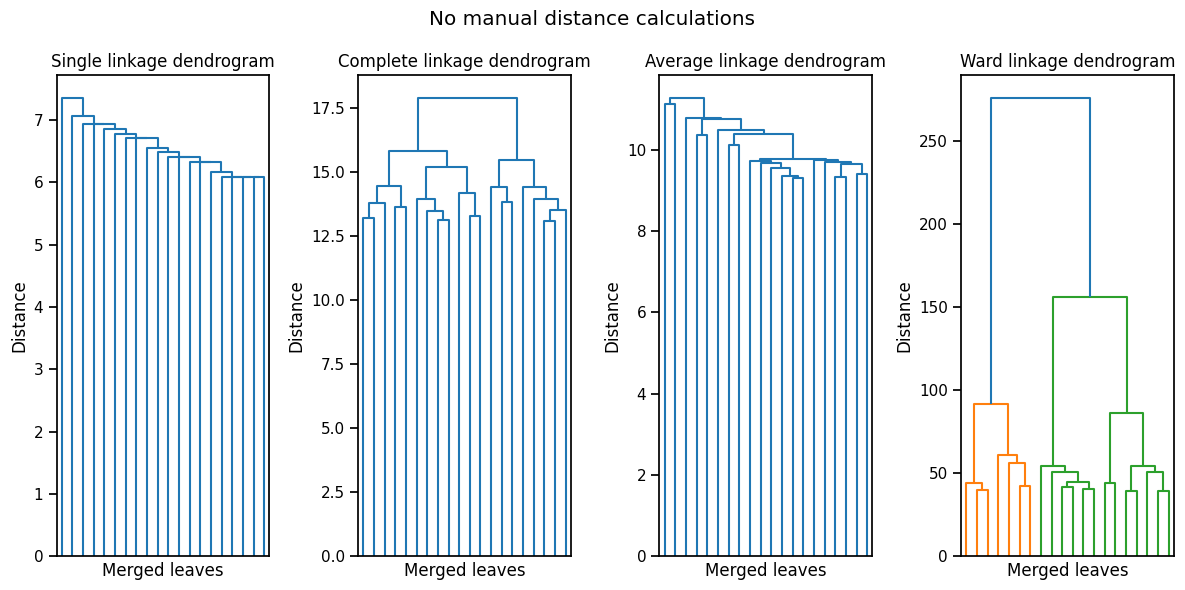

In [29]:
# auto params per tree
p_show = 20
ct_single = 0.7 * Z_single_default[:, 2].max()
ct_complete = 0.7 * Z_complete_default[:, 2].max()
ct_average = 0.7 * Z_average_default[:, 2].max()
ct_ward = 0.7 * Z_ward[:, 2].max()

fig, ax = plt.subplots(1, 4, figsize=(12, 6))

# single linkage
dendrogram(
    Z_single_default,
    truncate_mode="lastp",
    p=min(p_show, Z_single_default.shape[0] + 1),
    color_threshold=ct_single,
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[0]
)
ax[0].set_title("Single linkage dendrogram")
ax[0].set_xlabel("Merged leaves")
ax[0].set_ylabel("Distance")

# complete linkage
dendrogram(
    Z_complete_default,
    truncate_mode="lastp",
    p=min(p_show, Z_complete_default.shape[0] + 1),
    color_threshold=ct_complete,
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[1]
)
ax[1].set_title("Complete linkage dendrogram")
ax[1].set_xlabel("Merged leaves")
ax[1].set_ylabel("Distance")

# average linkage
dendrogram(
    Z_average_default,
    truncate_mode="lastp",
    p=min(p_show, Z_average_default.shape[0] + 1),
    color_threshold=ct_average,
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[2]
)
ax[2].set_title("Average linkage dendrogram")
ax[2].set_xlabel("Merged leaves")
ax[2].set_ylabel("Distance")

# ward linkage
dendrogram(
    Z_ward,
    truncate_mode="lastp",
    p=min(p_show, Z_ward.shape[0] + 1),
    color_threshold=ct_ward, # ward has much larger heights, so use its own max
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[3]
)
ax[3].set_title("Ward linkage dendrogram")
ax[3].set_xlabel("Merged leaves")
ax[3].set_ylabel("Distance")

plt.suptitle("No manual distance calculations")
plt.tight_layout()
plt.show()

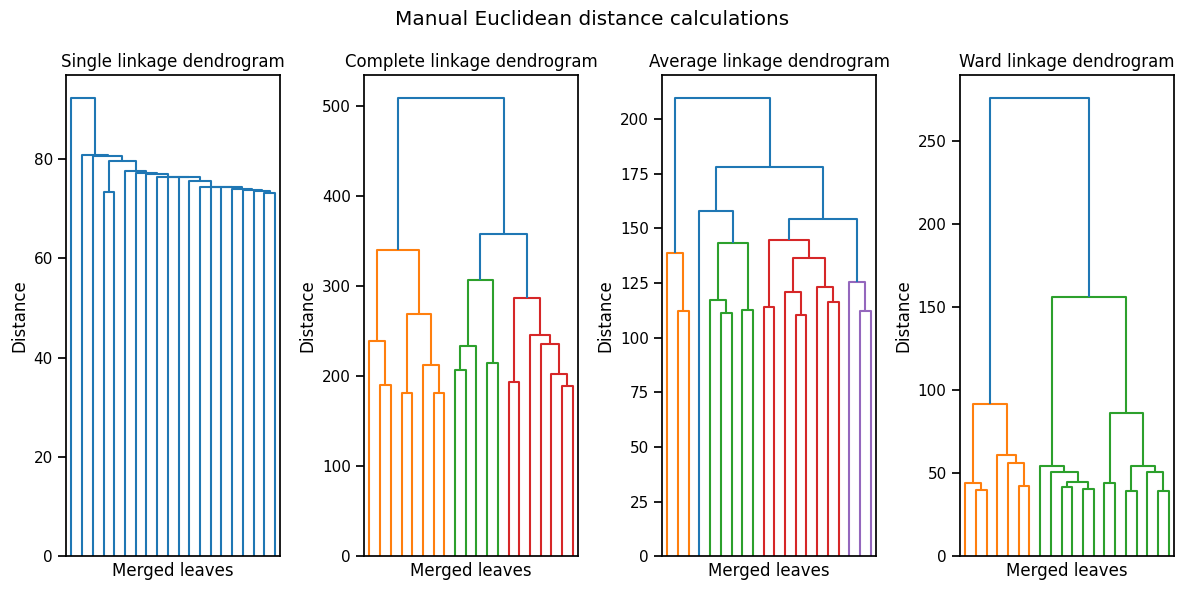

In [30]:
# auto params per tree
p_show = 20
ct_single = 0.7 * Z_single_euclidean[:, 2].max()
ct_complete = 0.7 * Z_complete_euclidean[:, 2].max()
ct_average = 0.7 * Z_average_euclidean[:, 2].max()
ct_ward = 0.7 * Z_ward[:, 2].max()

fig, ax = plt.subplots(1, 4, figsize=(12, 6))

# single linkage
dendrogram(
    Z_single_euclidean, 
    truncate_mode="lastp",
    p=min(p_show, Z_single_euclidean.shape[0] + 1),
    color_threshold=ct_single,
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[0]
)
ax[0].set_title("Single linkage dendrogram")
ax[0].set_xlabel("Merged leaves")
ax[0].set_ylabel("Distance")

# complete linkage
dendrogram(
    Z_complete_euclidean,
    truncate_mode="lastp",
    p=min(p_show, Z_complete_euclidean.shape[0] + 1),
    color_threshold=ct_complete,
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[1]
)
ax[1].set_title("Complete linkage dendrogram")
ax[1].set_xlabel("Merged leaves")
ax[1].set_ylabel("Distance")

# average linkage
dendrogram(
    Z_average_euclidean,
    truncate_mode="lastp",
    p=min(p_show, Z_average_euclidean.shape[0] + 1),
    color_threshold=ct_average,
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[2]
)
ax[2].set_title("Average linkage dendrogram")
ax[2].set_xlabel("Merged leaves")
ax[2].set_ylabel("Distance")

# ward linkage
dendrogram(
    Z_ward,
    truncate_mode="lastp",
    p=min(p_show, Z_ward.shape[0] + 1),
    color_threshold=ct_ward, # ward has much larger heights, so use its own max
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[3]
)
ax[3].set_title("Ward linkage dendrogram")
ax[3].set_xlabel("Merged leaves")
ax[3].set_ylabel("Distance")

plt.suptitle("Manual Euclidean distance calculations")
plt.tight_layout()
plt.show()

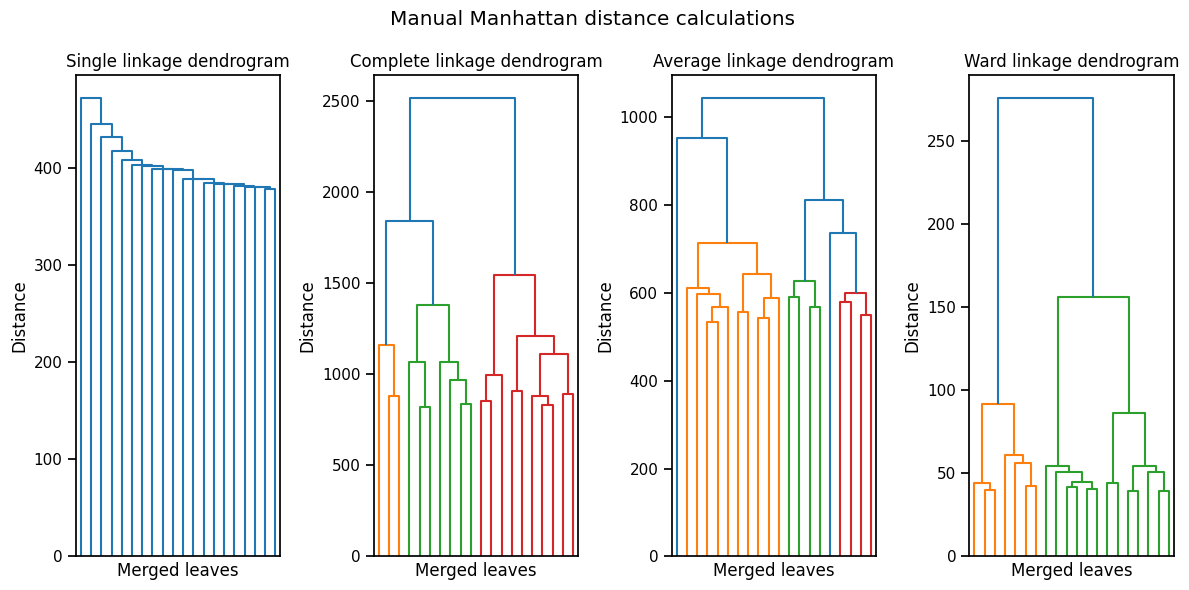

In [32]:
# auto params per tree
p_show = 20
ct_single = 0.7 * Z_single_manhattan[:, 2].max()
ct_complete = 0.7 * Z_complete_manhattan[:, 2].max()
ct_average = 0.7 * Z_average_manhattan[:, 2].max()
ct_ward = 0.7 * Z_ward[:, 2].max()

fig, ax = plt.subplots(1, 4, figsize=(12, 6))

# single linkage
dendrogram(
    Z_single_manhattan,
    truncate_mode="lastp",
    p=min(p_show, Z_single_manhattan.shape[0] + 1),
    color_threshold=ct_single,
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[0]
)
ax[0].set_title("Single linkage dendrogram")
ax[0].set_xlabel("Merged leaves")
ax[0].set_ylabel("Distance")

# complete linkage
dendrogram(
    Z_complete_manhattan,
    truncate_mode="lastp",
    p=min(p_show, Z_complete_manhattan.shape[0] + 1),
    color_threshold=ct_complete,
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[1]
)
ax[1].set_title("Complete linkage dendrogram")
ax[1].set_xlabel("Merged leaves")
ax[1].set_ylabel("Distance")

# average linkage
dendrogram(
    Z_average_manhattan,
    truncate_mode="lastp",
    p=min(p_show, Z_average_manhattan.shape[0] + 1),
    color_threshold=ct_average,
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[2]
)
ax[2].set_title("Average linkage dendrogram")
ax[2].set_xlabel("Merged leaves")
ax[2].set_ylabel("Distance")

# ward linkage
dendrogram(
    Z_ward,
    truncate_mode="lastp",
    p=min(p_show, Z_ward.shape[0] + 1),
    color_threshold=ct_ward, # ward has much larger heights, so use its own max
    no_labels=True,
    count_sort="ascending",
    distance_sort="descending",
    ax=ax[3]
)
ax[3].set_title("Ward linkage dendrogram")
ax[3].set_xlabel("Merged leaves")
ax[3].set_ylabel("Distance")

plt.suptitle("Manual Manhattan distance calculations")
plt.tight_layout()
plt.show()

## Interpretation of dendrograms
1. **Short merge height** --> particpants answered very similarly across 20 questions.
2. **Tall merge height** --> participants answered very differently across 20 questions.
3. **Single Linkage**:
    - Tall chain without clear, wide separations.
    - No clean clusters because single linkage clusters based on closest pairs; everyone linked gradually with incremental differences.
    - *Responses are distributed smoothly, no strong or isolated subgroups.*
4. **Complete Linkage**:
    - Merges based on farthest pairs.
    - Tall last merge and relatively balanced sub-branches suggest a few well-separated groups at the top.
    - *There may be a handful of distinct response profiles, maybe high vs low MACH-IV scores, with smaller inter-group variation.*
5. **Average Linkage**:
    - Averages all pairwise distances between clusters.
    - Similar to complete linkage but smoother, indicating moderately distinct and overlapping groups.
    - *Multiple gradations of Machiavellian tendencies rather than sharply distinct clusters.*
6. **Ward Linkage**:
    - Minimizes inter-cluster variance.
    - Larger distance due to sqaured Euclidean distance.
    - Not appropriate to pre-compute distance matrices since it essentially does that internally.
    - Clear branching: 2-3 big clusters (depending on what you consider large) before a massive final merge.
    - *Likely the most informative, suggests 2-3 main subgroups, perhaps low-mach, medium-mach, high-mach.*
## Main takeaways
- The structure is more graded, which suggests Machiavellianism is a spectrum rather than its own distinct personality type (aligns with accepted understanding).
- **Ward linkage** offers the most interpretable hierarchy for psychological traits; could be cut into 2-3 clusters.
- Manhattan distance could *slightly* improve interpretability.